## MTC evaluation - part 2


### Summary

- Overall performance comparison 
- Scalability analysis

### Main takeaways

Despite often scoring the lowest out of all the models, MTC still displays satistfying accuracy, its average MCC across the different datasets not being too distant from that of the best performing models:
- .3 ca from the absolute best in 1/4 cases;
- .1 ca in 2/4 cases;
- .01 on the Breast Cancer dataset. 

On the other hand, MTC outperforms almost all the models when it comes to computational efficiency:
- training time
    - is significantly lower than RF, AdaBoost and SVM;
    - is aligned with k-NN (which has a higher prediction time)
- prediction time
    - is aligned with RF, AdaBoost and SVM;
    - is lower than k-NN.
    
To conclude, MTC's performance displays an interesting blend between accuracy and efficiency.   
Further insight is expected as a result of sensitivity analysis.

As expected, results from the scalability test are satisfying: 
- prediction time grows linearly with the size of the dataset,
- testing time remains (surprisingly) stable. 

# 2.1. Overall performance comparison

We ran a **comparative evaluation**, using MTClassifier alongside other common **machine learning algorithms**.

Given MTC's characteristics, the following algorithms were selected for the analysis:
- Random Forest
- AdaBoost
- Support Vector Machine 
- k-Nearest Neighbors

### Procedure
Data creation/retrieval and scaling are carried out as a preprocessing step.

Then, models are initialized: 
   - MTC with best parameters, resulted from tuning (see eval_1);
   - the other models have also been previously tuned - some parameters are set according to literature indications;
   
A **K-fold cross validation** mechanism is **nested in the evaluation** procedure for more robust results:

1. K folds are created; 

2. For each fold:
    - training data is split in training and validation sets;
    - each classifier is trained and evaluated on the validation set;
    - metrics and time are calculated ;
3. Average metrics - on the k folds - are computed:
    - Matthew's Correlation Coefficient - main metric for our analysis
    - Cohen's Kappa Score - to monitor coherence, in case any anomalies arise in MCCs
    - Training time
    - Prediction time
3. (Each class is also evaluated (same metrics) on the test set);  
    - not currently implemented as of now
    - we still create the test set, in case we need to compare predictions from cross-validation

4. Results are visualized
    - three functions defined to plot MCCs and time metrics

### Data

The evaluation procedure is carried out on **different datasets**:

- 2 synthetic datasets;
- 3 real_world datasets:
    - the Breast Cancer dataset;
    - the Forest Covtype (sampled at 10%);
    - the Labeled Faces in the Wild (LFW) pairs dataset.



In [4]:
#import classes
from MTC2 import MTClust, MTClustT, MTClassifier

#import libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, sample, seed
import time

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

#import algorithms
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [88]:
#initialize models
rf = RandomForestClassifier(n_estimators=200, random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),learning_rate=0.1, n_estimators=200, random_state=42)
svm = SVC(C=10, probability=True, random_state=42)
knn = KNeighborsClassifier(metric='euclidean')
seed(7)
mtc = MTClassifier(n_parts=10, max_depth=20, min_instances=5, use_binary_class=True, dist_func="euclidean")

#store initialized models in a dictionary
classifiers = {
    "Random Forest": rf,
    "AdaBoost": ada,
    "Support Vector Machine": svm,
    "k-Nearest Neighbors": knn,
    "MTClassifier": mtc
}

## Dataset A - synthetic

30k instances but few features, 0.2 informative feature ratio, imbalanced (2:1 ratio) but one cluster per class

In [63]:
#create dataset
X, y = make_classification(
    n_samples=30000,
    n_features=25,
    n_informative=2,
    n_redundant=3,
    
    n_classes=2,
    n_clusters_per_class=1,
    weights=[0.67,0.33],
    flip_y=0.02,
    class_sep=0.6,
    
    random_state=42)

#train/test split, scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.954, Cohen's Kappa Score: 0.954
    Training Time: 16.623s, Prediction Time: 0.203s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.940, Cohen's Kappa Score: 0.939
    Training Time: 33.923s, Prediction Time: 0.186s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.798, Cohen's Kappa Score: 0.794
    Training Time: 58.906s, Prediction Time: 4.655s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.637, Cohen's Kappa Score: 0.618
    Training Time: 0.002s, Prediction Time: 5.355s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.649, Cohen's Kappa Score: 0.636
    Training Time: 3.722s, Prediction Time: 0.950s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest - Mat

### Defining functions for visualization

- Boxplots for MCCs scores distributions
    - not really informative: boxes are very narrow as variance is low
    - most likely will not appear in the report
- Barplots for average MCC across the folds
- Barplots for training and prediction times

In [65]:
def plotBoxplots(metrics, classifiers):
    
    colors = ['darkorchid', 'darkblue', 'mediumturquoise', 'mediumseagreen', 'yellowgreen']
    fig, ax = plt.subplots(figsize=(8, 7))
    
    mccs = [metrics["Matthews Correlation Coefficient"][clf_name] for clf_name in classifiers.keys()]
    bp = ax.boxplot(mccs, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_title(f'Distribution of {metric_name} Scores Across Algorithms', fontsize=15)
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_xticks(list(range(1, len(classifiers) + 1)))
    ax.set_xticklabels(classifiers.keys(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)

    plt.tight_layout()
    plt.show()

#plot_boxplots(metrics, classifiers)

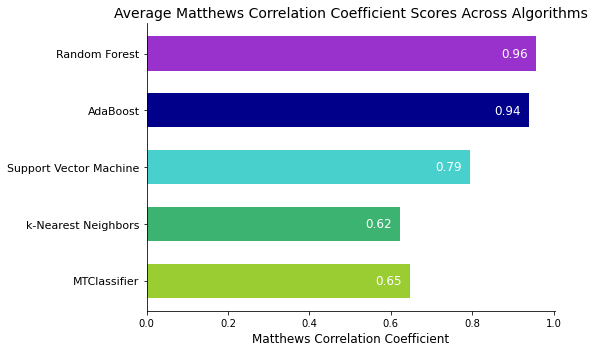

In [69]:
def plotBars(metrics, classifiers, bar_thickness=0.5):
    
    colors = ['darkorchid', 'darkblue', 'mediumturquoise', 'mediumseagreen', 'yellowgreen']
    fig, ax = plt.subplots(figsize=(8, 5))
    
    #retrieve average MCCs
    mcc_avg = [average_metrics[clf_name]["Matthews Correlation Coefficient"][0] for clf_name in classifiers.keys()]

    bars = ax.barh(range(len(classifiers)), mcc_avg, color=colors, height=bar_thickness)
    ax.set_yticks(list(range(len(classifiers))))
    ax.set_yticklabels(classifiers.keys(), fontsize=11)
    ax.invert_yaxis()

    for i, bar in enumerate(bars):
        ax.text(bar.get_width() - 0.02, bar.get_y() + bar.get_height()/2, 
                f'{mcc_avg[i]:.2f}', 
                va='center', ha='right', color='white', fontsize=12)

    ax.set_title('Average Matthews Correlation Coefficient Scores Across Algorithms', fontsize=14)
    ax.set_xlabel('Matthews Correlation Coefficient', fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    plt.tight_layout()
    plt.show()

plotBars(metrics, classifiers, bar_thickness=0.6)

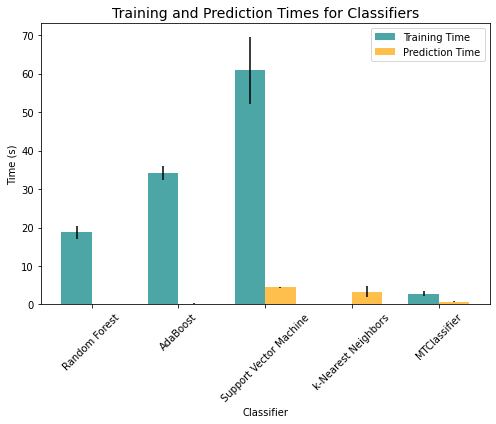

In [71]:
def plotTimes(average_metrics, classifiers):
    
    #retrieve means and standard deviations for time metrics
    tt_mean = [average_metrics[clf_name]["Training Time"][0] for clf_name in classifiers.keys()]
    tt_std = [average_metrics[clf_name]["Training Time"][1] for clf_name in classifiers.keys()]
    pt_mean = [average_metrics[clf_name]["Prediction Time"][0] for clf_name in classifiers.keys()]
    pt_std = [average_metrics[clf_name]["Prediction Time"][1] for clf_name in classifiers.keys()]

    bar_width = 0.35
    index = np.arange(len(classifiers))
    
    fig, ax = plt.subplots(figsize=(7, 6))

    bars1 = ax.bar(index, tt_mean, bar_width, yerr=tt_std,
                   label='Training Time', alpha=0.7, color='teal')
    bars2 = ax.bar(index + bar_width, pt_mean, bar_width, yerr=pt_std,
                   label='Prediction Time', alpha=0.7, color='orange')
    
    ax.set_xlabel('Classifier')
    ax.set_ylabel('Time (s)')
    ax.set_title('Training and Prediction Times for Classifiers', fontsize=14)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(classifiers.keys())
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plotTimes(average_metrics, classifiers)

## Dataset B - synthetic

5k instances but high number of features, 0.2 informative feature ratio, balanced but two clusters per class

In [72]:
#create dataset
X, y = make_classification(
    n_samples=5000,
    n_features=100,
    n_informative=15,
    n_redundant=35,
    
    n_classes=2,
    n_clusters_per_class=2,
    weights=[0.5,0.5],
    flip_y=0.03,
    class_sep=0.9,
    
    random_state=42)

#train/test split, scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.847, Cohen's Kappa Score: 0.847
    Training Time: 3.203s, Prediction Time: 0.044s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.802, Cohen's Kappa Score: 0.802
    Training Time: 15.688s, Prediction Time: 0.074s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.875, Cohen's Kappa Score: 0.875
    Training Time: 2.445s, Prediction Time: 0.383s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.764, Cohen's Kappa Score: 0.763
    Training Time: 0.001s, Prediction Time: 0.096s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.728, Cohen's Kappa Score: 0.727
    Training Time: 0.368s, Prediction Time: 0.109s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest - Matth

In [ ]:
#plotBoxplots(metrics, classifiers)

Results for MTC - and kNN - were significantly lower (MCCs around 0.4) when the ratio of informative feature was 0.2

MTC doesn't cope well with noise??

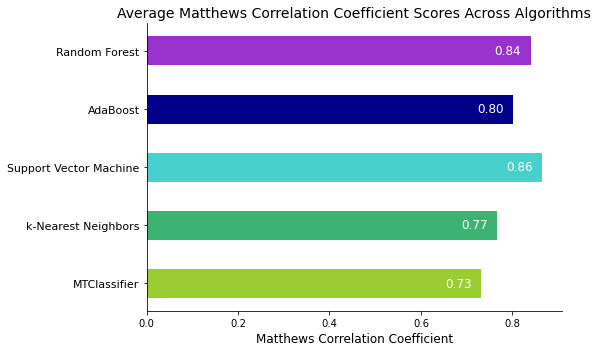

In [74]:
plotBars(metrics, classifiers, bar_thickness=0.50)

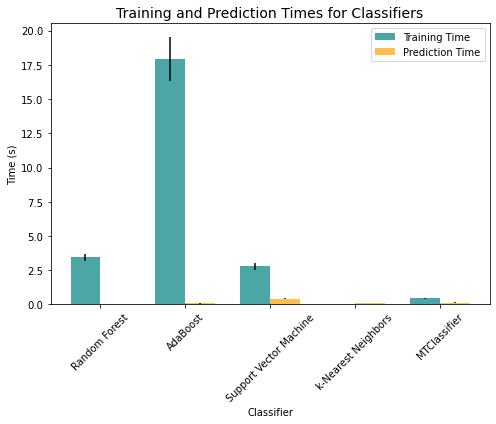

In [75]:
plotTimes(average_metrics, classifiers)

## Dataset C - Breast Cancer, Wisconsin dataset

In [76]:
from sklearn.datasets import load_breast_cancer

#load dataset
data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [77]:
#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.911, Cohen's Kappa Score: 0.910
    Training Time: 0.304s, Prediction Time: 0.016s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.883, Cohen's Kappa Score: 0.883
    Training Time: 0.677s, Prediction Time: 0.022s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.955, Cohen's Kappa Score: 0.955
    Training Time: 0.009s, Prediction Time: 0.001s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.941, Cohen's Kappa Score: 0.941
    Training Time: 0.001s, Prediction Time: 0.006s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.941, Cohen's Kappa Score: 0.941
    Training Time: 0.017s, Prediction Time: 0.004s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest - Matthe

In [78]:
#plotBoxplots(metrics, classifiers)

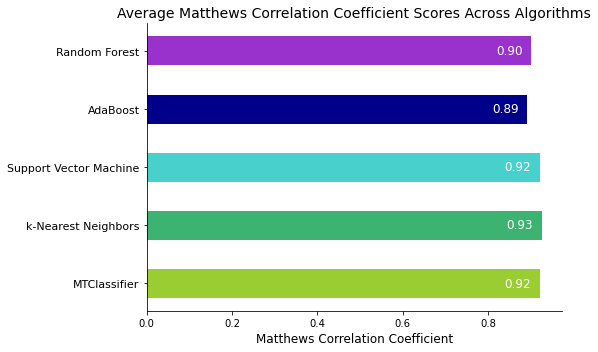

In [79]:
plotBars(metrics, classifiers, bar_thickness=0.50)

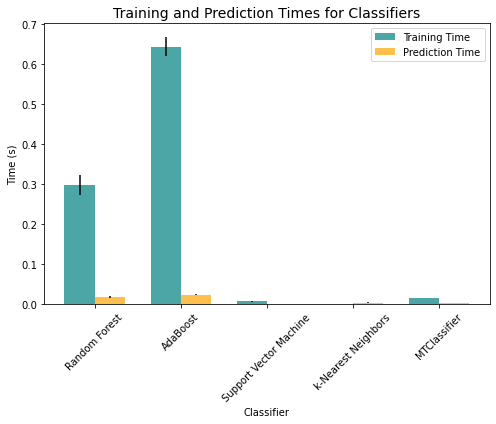

In [80]:
plotTimes(average_metrics, classifiers)

## Dataset D - Forest Covertype

- Orginal dataset is too large (500k+ instances): using 10% of the samples
- had to set *use_binary_class=False*, as MTClustT allows binary classification only

In [81]:
from sklearn.datasets import fetch_openml

#fetch dataset 
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
column_names = [f"feat_{i}" for i in range(1, 55)] + ["Cover_Type"]
data_df = pd.read_csv(url, header=None, names=column_names)


In [82]:
#split dataset into features and target
#X = data_df.drop(columns=["Cover_Type"]).values
#y = data_df["Cover_Type"].values

##PROBLEM: COVTYPE IS TOO BIG: WE HAVE TO SAMPLE

#create a stratified sample
sample_fraction = 0.1
data_sample = data_df.groupby('Cover_Type').apply(lambda x: x.sample(frac=sample_fraction)).reset_index(drop=True)

X = data_sample.drop(columns=["Cover_Type"]).values
y = data_sample["Cover_Type"].values

#train/test split, scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
#setup kfold, storage structures
num_folds = 3
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.790, Cohen's Kappa Score: 0.788
    Training Time: 9.894s, Prediction Time: 0.658s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.373, Cohen's Kappa Score: 0.371
    Training Time: 18.495s, Prediction Time: 0.807s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.650, Cohen's Kappa Score: 0.648
    Training Time: 381.387s, Prediction Time: 54.881s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.700, Cohen's Kappa Score: 0.699
    Training Time: 0.004s, Prediction Time: 13.656s

    Evaluating MTClassifier...
    MTClassifier - Matthews Correlation Coefficient: 0.655, Cohen's Kappa Score: 0.651
    Training Time: 5.309s, Prediction Time: 2.136s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Co

In [61]:
#plot_boxplots(metrics, classifiers)

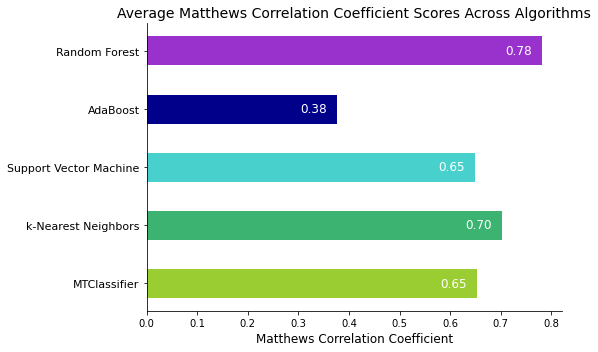

In [86]:
plotBars(metrics, classifiers, bar_thickness=0.50)

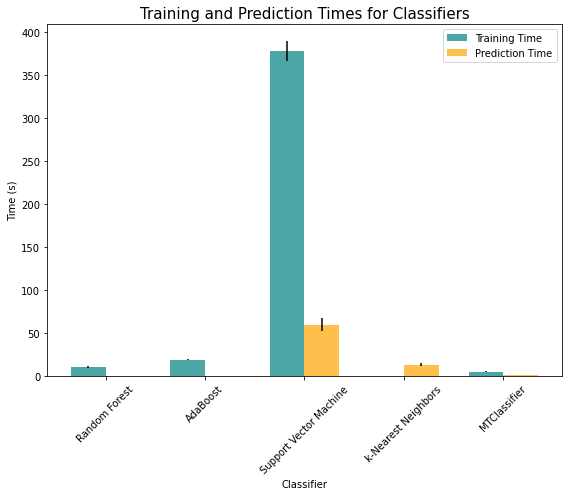

In [87]:
plot_times(average_metrics, classifiers)

## Dataset E - ?

It would be interesting to try one more real world dataset.  
Tried the **LFW pairs**, MCCs all 0s, very low scores...  
  
    
Maybe lets try again with 5 folds instead of 3.

In [89]:
from sklearn.datasets import fetch_lfw_pairs

lfw_pairs_train = fetch_lfw_pairs(subset='train')
lfw_pairs_test = fetch_lfw_pairs(subset='test')

#accessing data
X_train = lfw_pairs_train.data
y_train = lfw_pairs_train.target

X_test = lfw_pairs_test.data
y_test = lfw_pairs_test.target

In [90]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [92]:
#setup kfold, storage structures
num_folds = 5
fold_size = len(X_train) // num_folds

metrics = {
    "Matthews Correlation Coefficient": {},
    "Cohen's Kappa Score": {},
    "Training Time": {},
    "Prediction Time": {}
}

for clf_name in classifiers.keys():
    for metric_name in metrics.keys():
        metrics[metric_name][clf_name] = []

for fold in range(num_folds):
    print(f"Evaluating fold {fold + 1}...")
    
    #split training data in training/validation sets
    val_indices = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_indices = list(range(0, fold * fold_size)) + list(range((fold + 1) * fold_size, len(X_train)))
    
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    
    #evaluation
    for clf_name, clf in classifiers.items():
        print(f"    Evaluating {clf_name}...")
        
        start_time = time.time()
        clf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        metrics["Training Time"][clf_name].append(end_time - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(X_val_fold)
        end_time = time.time()
        metrics["Prediction Time"][clf_name].append(end_time - start_time)
        
        metrics["Matthews Correlation Coefficient"][clf_name].append(matthews_corrcoef(y_val_fold, y_pred))
        metrics["Cohen's Kappa Score"][clf_name].append(cohen_kappa_score(y_val_fold, y_pred))
        
        #results
        cohen_key = "Cohen's Kappa Score"
        print(f"    {clf_name} - Matthews Correlation Coefficient: {metrics['Matthews Correlation Coefficient'][clf_name][-1]:.3f}, "
              f"{cohen_key}: {metrics[cohen_key][clf_name][-1]:.3f}")
        print(f"    Training Time: {metrics['Training Time'][clf_name][-1]:.3f}s, "
              f"Prediction Time: {metrics['Prediction Time'][clf_name][-1]:.3f}s\n")

#average results by classifier
average_metrics = {}
for clf_name in classifiers.keys():
    average_metrics[clf_name] = {}
    print(f"Average Metrics for {clf_name}:")
    for metric_name in metrics.keys():
        avg_metric = np.mean(metrics[metric_name][clf_name])
        std_metric = np.std(metrics[metric_name][clf_name])
        average_metrics[clf_name][metric_name] = (avg_metric, std_metric)
        print(f"    {metric_name}: {avg_metric:.3f} ± {std_metric:.3f}")

Evaluating fold 1...
    Evaluating Random Forest...
    Random Forest - Matthews Correlation Coefficient: 0.000, Cohen's Kappa Score: 0.000
    Training Time: 18.518s, Prediction Time: 0.040s

    Evaluating AdaBoost...
    AdaBoost - Matthews Correlation Coefficient: 0.000, Cohen's Kappa Score: 0.000
    Training Time: 526.195s, Prediction Time: 0.402s

    Evaluating Support Vector Machine...
    Support Vector Machine - Matthews Correlation Coefficient: 0.000, Cohen's Kappa Score: 0.000
    Training Time: 66.739s, Prediction Time: 8.839s

    Evaluating k-Nearest Neighbors...
    k-Nearest Neighbors - Matthews Correlation Coefficient: 0.000, Cohen's Kappa Score: 0.000
    Training Time: 0.011s, Prediction Time: 0.496s

    Evaluating MTClassifier...
Binary classification
    MTClassifier - Matthews Correlation Coefficient: 0.000, Cohen's Kappa Score: 0.000
    Training Time: 5.135s, Prediction Time: 0.618s

Evaluating fold 2...
    Evaluating Random Forest...
    Random Forest - Ma

Something went clearly wrong. Will fix it.

# 2.2. Scalability test

To test how well would MTC scale:
1. A large dataset of 500k instances was generated;
2. Different subsample sizes were defined;
3. On each subsample:
    - MTC was run to fit and predict
    - Training and prediction times were recorded.

In [58]:
#create dataset
X_st, y_st = make_classification(
    n_samples=500000,
    n_features=200,
    n_informative=20,
    n_redundant=20,
    
    n_classes=2,
    n_clusters_per_class=2,
    weights=[0.2,0.8],
    class_sep=0.,
    
    random_state=42)

#split
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X_st, y_st, test_size=0.25, random_state=42)

#MTC instance
mtc = MTClassifier(n_parts=10, max_depth=20, min_instances=5, use_binary_class=True, dist_func="euclidean")

#define subsample sizes
subsample_sizes = [0.1, 0.2, 0.5, 1.0]

In [59]:
#store training times, prediction times, MCC scores
train_times = []
predict_times = []
mcc_scores = []

#evaluate on subsamples
for size in subsample_sizes:
    
    sample_size = int(size * X_train_st.shape[0])
    X_subsample = X_train_st[:sample_size]
    y_subsample = y_train_st[:sample_size]

    start_time = time.time()
    mtc.fit(X_subsample, y_subsample)
    train_time = time.time() - start_time

    start_time = time.time()
    predictions = mtc.predict(X_test_st)
    predict_time = time.time() - start_time

    mcc = matthews_corrcoef(y_test_st, predictions)

    #store results
    train_times.append(train_time)
    predict_times.append(predict_time)
    mcc_scores.append(mcc)
    
    print(f"Size: {size:.2f}, Train time: {train_time:.4f}s, Predict time: {predict_time:.4f}s, MCC: {mcc:.4f}")

Binary classification
Size: 0.10, Train time: 12.1217s, Predict time: 23.1567s, MCC: 0.6887
Binary classification
Size: 0.20, Train time: 31.7814s, Predict time: 23.5229s, MCC: 0.7202
Binary classification
Size: 0.50, Train time: 90.7176s, Predict time: 27.2863s, MCC: 0.7541
Binary classification
Size: 1.00, Train time: 201.8141s, Predict time: 26.9476s, MCC: 0.7662


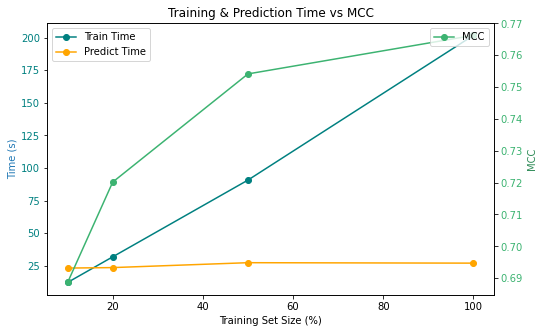

In [63]:
#plot
plot_size = (8, 5)
fig, ax1 = plt.subplots(figsize=plot_size)

ax1.set_xlabel('Training Set Size (%)')
ax1.set_ylabel('Time (s)', color='tab:blue')
ax1.plot([size*100 for size in subsample_sizes], train_times, label='Train Time', color='teal', marker='o')
ax1.plot([size*100 for size in subsample_sizes], predict_times, label='Predict Time', color='orange', marker='o')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('MCC', color='seagreen')
ax2.plot([size*100 for size in subsample_sizes], mcc_scores, label='MCC', color='mediumseagreen', marker='o')
ax2.tick_params(axis='y', labelcolor='mediumseagreen')
ax2.legend(loc='upper right')

plt.title('Training & Prediction Time vs MCC')
plt.show()